In [73]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [32]:
sdss = Table.read('sdss_m2_period.txt', format='ascii')

In [33]:
sdss

ID,IAU NAME,M2,porb,M2e,porbe
int64,str24,float64,float64,float64,float64
64,SDSSJ005245.11-005337.2,0.319,2.735,0.09,0.002
81,SDSSJ011009.09+132616.1,0.319,7.984495,0.09,3e-06
117,SDSSJ013851.54-001621.6,0.255,1.746529272,0.124,1e-09
127,SDSSJ015225.38-005808.5,0.196,2.1519468,0.085,9.9e-06
170,SDSSJ022503.02+005456.2,0.294,21.86,0.09,0.16
182,SDSSJ023804.39-000545.7,0.38,5.0801,0.072,0.0048
189,SDSSJ024642.55+004137.2,0.38,17.43,0.072,0.04
217,SDSSJ030308.35+005444.1,0.287,3.226505,0.107,1e-06
229,SDSSJ031404.98-011136.6,0.319,6.32,0.09,0.02


<ErrorbarContainer object of 3 artists>

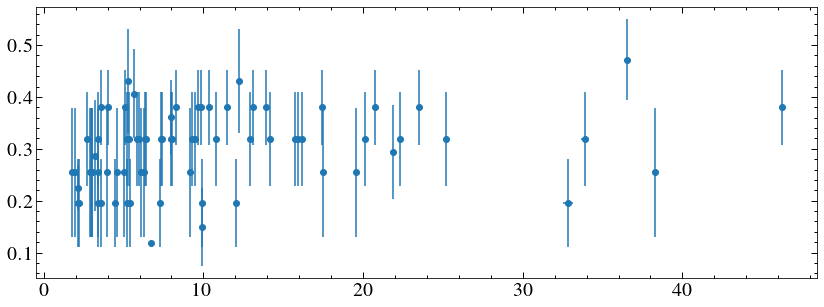

In [155]:
plt.errorbar(sdss['porb'], sdss['M2'], xerr=sdss['porbe'], yerr=sdss['M2e'], marker='o', ls='none')
#plt.errorbar()

In [157]:
period = 4.226953752501198
pe = 0.2
m2 = 0.08224821973550357
m2e = 0.009135699983472514

(0, 30)

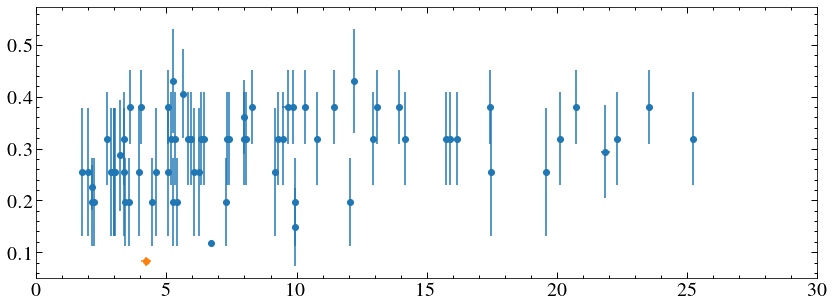

In [158]:
plt.errorbar(sdss['porb'], sdss['M2'], xerr=sdss['porbe'], yerr=sdss['M2e'], marker='o', ls='none')
plt.errorbar(period, m2, xerr=pe, yerr=m2e, marker='o', ls='none')
plt.xlim(0, 30)

Photometry- make a nice plot

In [37]:
phot_files = glob.glob('ultracam/*.dat')
phot_files

['ultracam/1144_g.dat', 'ultracam/1144_i.dat', 'ultracam/1144_u.dat']

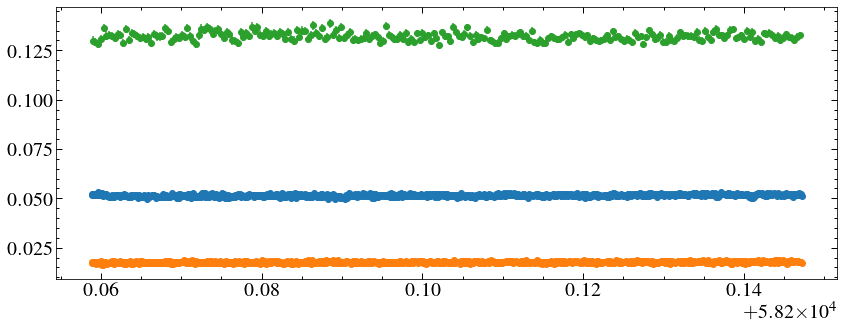

In [40]:
for pht in phot_files:
    t, f, e = np.loadtxt(pht, unpack=True)
    plt.errorbar(t, f, yerr=e,marker='o', ls='none')

In [44]:
from  craftroom import resample

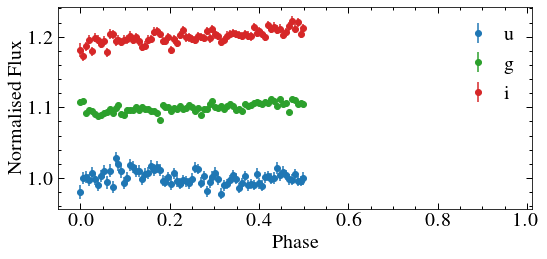

In [78]:
phot_files = ['ultracam/1144_u.dat', 'ultracam/1144_g.dat', 'ultracam/1144_i.dat']


labels = [ 'u','g', 'i']
colors = ['C0','C2', 'C3']

plt.figure(figsize=(8, 4))
for i, pht in enumerate(phot_files):
    t, f, e = np.loadtxt(pht, unpack=True)
    nf, ne = f/np.median(f), e/np.median(f)
    nt = (t-t[0]) *24
    nt , nf, ne = resample.bintogrid(nt, nf, ne, dx=100/3600)
    #nf = convolve(nf,Box1DKernel(smooth))
    #ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    plt.errorbar(nt/period, nf+i*0.1, yerr=ne,marker='o', ls='none', label=labels[i], c=colors[i])
    plt.legend()
    plt.xlabel('Phase')
    plt.ylabel('Normalised Flux')
    plt.xlim(-0.05, 1.01)
    plt.tight_layout()
    plt.savefig('1144_phot.png', dpi=150)

NIR? Has it's own notebook. Inclination

In [141]:
m1 = 0.49*const.M_sun
m2 = 0.01*const.M_sun
ph = period*u.hour
ps = ph.to(u.s)
v1 = 33*u.km/u.s
v2 = 196.6*u.km/u.s
G = const.G

In [151]:
#a = ((((const.G*0.5*u.Msun*(4.2*u.hour)**2)/(4*np.pi)**2))**(1/3)).to(u.Rsun)
a = ((G*(m1+m2)*(ps**2))/(4*np.pi**2))**(1/3)
print(a.to(u.Rsun))
vsini = ((G*(m1))/a)**0.5
print(vsini)
#vsini = ((((2*np.pi)**(2/3))*G*(m1))/((G*(ps**2)*(m1+m2))**(1/3)))**0.5
#print(vsini)

1.0494746720996317 solRad
298439.8921885167 m / s


In [152]:
sini = v2.to(u.m/u.s)/vsini
sini

<Quantity 0.65875912>

In [153]:
np.arcsin(sini).to(u.deg)

<Quantity 41.20530457 deg>

In [154]:
vsini2 = ((G*(m2))/a)**0.5
sini2 = v1.to(u.m/u.s)/vsini2
np.arcsin(sini2).to(u.deg)

<Quantity 50.71673809 deg>

Can I make some relativly calibrated spectra? - scale the blue to the wd model?

In [161]:
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

uvbpath = path + 'UVB/'
usp = glob.glob(uvbpath+'*.csv')
merge = glob.glob(uvbpath+'*merged.csv')[0]
usp.remove(merge)
print(len(usp))

vispath = path + 'VIS_notell/'
vsp = glob.glob(vispath+'*TAC.csv')
#merge = glob.glob(vispath+'*merged.csv')[0]
#sp.remove(merge)
print(len(vsp))

nirpath = path + 'NIR/'
nsp = glob.glob(nirpath+'*.csv')
merge = glob.glob(nirpath+'*merged.csv')[0]
nsp.remove(merge)
print(len(nsp))

33
33
29


In [162]:
usp[0], vsp[0], nsp[0]

('/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_9.csv',
 '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_30_TAC.csv',
 '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/NIR/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_NIR_23.csv')

In [164]:
usp[0][-6:-3]

'_9.'

In [167]:
for uvb in usp:
    print(uvb)
    num = uvb[-6:-3]
    vis = glob.glob(vispath+'*'+num+'*')[0]
    print(vis)

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/UVB/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_UVB_9.csv


IndexError: list index out of range